In [1]:
import json
import random
import matplotlib.pyplot as plt

In [2]:
REVIEW_PATH = "../data/yelp_academic_dataset_review.json"

def read_data(limit: int) -> list:
    lengths = []
    with open(REVIEW_PATH) as f:
        for idx, line in enumerate(f):
            if idx >= limit:
                break
            lengths.append(len(json.loads(line)["text"]))

    # lengths = np.array([[l] for l in lengths])
    return lengths

lengths = read_data(1000)

In [3]:
def shift_mode(point, data, h):
    weights = [0 if abs(point - x) > h else 1 for x in data]
    weighted_sum = sum([data[i] * weights[i] for i in range(len(data))])
    total_weights = sum(weights)

    if total_weights != 0:
        return weighted_sum / total_weights
    else:
        return point

def mean_shift(data, h, threshold: float = 1e-5):

    mode = [[] for _ in range(len(data))]
    for i in range(len(data)):
        m = 0
        mode[i].append(data[i])
        while True:
            mode[i].append(shift_mode(mode[i][m], data, h))
            m += 1
            if abs(mode[i][m] - mode[i][m-1]) < threshold:
                break
        mode[i][0] = mode[i][m]

    C = []
    for i in range(len(data)):
        if mode[i][0] not in C:
            C.append(mode[i][0])

    labels = []
    for point in data:
        distances = [abs(point - c) for c in C]
        label = distances.index(min(distances))
        labels.append(label)

    return C, labels

In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [5]:
def plot(ax, data, labels):
	prop_cycle = plt.rcParams['axes.prop_cycle']
	colors = prop_cycle.by_key()['color']


	for i, cluster in enumerate(labels):
		ax.scatter(data[i], [cluster], s=1, c=colors[int(cluster)],label=f'Cluster {cluster+1}')
		# plt.show()

h = 300, number of clusters = 8
h = 500, number of clusters = 3
h = 700, number of clusters = 2
h = 1000, number of clusters = 2
h = 1500, number of clusters = 1
h = 2000, number of clusters = 1


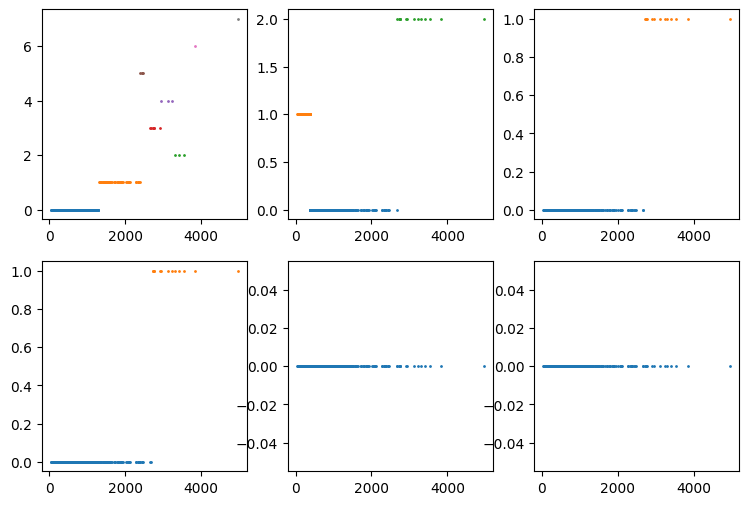

In [6]:
bandwidths = [300, 500, 700, 1000, 1500, 2000]
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9, 6))

for ax, h in zip(axes.ravel(), bandwidths):
	centroids, labels = mean_shift(lengths, h, 0.001)
	print(f"h = {h}, number of clusters =", len(centroids))
	if len(centroids) <= len(colors):
		plot(ax, lengths, labels)

plt.show()

# Second attempt

In [7]:
REVIEW_PATH = "../data/yelp_academic_dataset_review.json"

def read_data(limit: int):
    lengths = []
    reviews = []
    with open(REVIEW_PATH) as f:
        for idx, line in enumerate(f):
            if idx >= limit:
                break
            review = json.loads(line)["text"]
            lengths.append(len(review))
            reviews.append(review)
    # lengths = np.array([[l] for l in lengths])
    return lengths, reviews

lengths, reviews = read_data(1000)

In [8]:
def calculate_manhattan_distance(point1, point2):
    return abs(point1 - point2)

def flat_kernel(point1, point2, h, dist_func):
    return 1 if dist_func(point1, point2) <= h else 0

def shift_mode(point, data, h, dist_func):
    total_weights = 0
    weighted_sum = 0
    for i in range(len(data)):
        weight = flat_kernel(point, data[i], h, dist_func)
        total_weights += weight
        weighted_sum += weight * data[i]
        
    if total_weights != 0:
        return weighted_sum / total_weights
    else:
        return point

def mean_shift(data, h, dist_func, threshold: float = 1e-5):

    mode = [[] for _ in range(len(data))]
    for i in range(len(data)):
        m = 0
        mode[i].append(data[i])
        while True:
            mode[i].append(shift_mode(mode[i][m], data, h, dist_func))
            m += 1
            if abs(mode[i][m] - mode[i][m-1]) < threshold:
                break
        mode[i][0] = mode[i][m]

    # C = {}
    # for i in range(len(data)):
    #     if mode[i][0] not in C:
    #         C[mode[i][0]] = [data[i]]
    #     else:
    #         C[mode[i][0]].append(data[i])

    # return C

    centroids = []
    for i in range(len(data)):
        if mode[i][0] not in centroids:
            centroids.append(mode[i][0])

    labels = []
    for i in range(len(data)):
        labels.append(centroids.index(mode[i][0]))

    return centroids, labels

In [16]:
centroids, labels = mean_shift(lengths, 500, calculate_manhattan_distance)

clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = [reviews[i]]
    else:
        clusters[label].append(reviews[i])

for i, (k, v) in enumerate(clusters.items()):
    print(f"Cluster {i} with centroid {centroids[k]}: {len(v)} reviews, average length is {sum([len(review) for review in v]) / len(v)}")
    print("######################")
    for review in v[:10]:
        print(review)
        print("---")

Cluster 0 with centroid 377.2633495145631: 542 reviews, average length is 859.4428044280443
######################
If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. 

The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.
---
I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.

For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way 

# Object-Oriented Implementation

In [18]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List


class LengthVectorizer:
    def __init__(self):
        pass

    def fit(self, data: List[str]):
        return [len(s) for s in data]


class Point(ABC):
    @abstractmethod
    def __init__(self, coordinates):
        self.coordinates = coordinates

    @abstractmethod
    def distance(self, other: Point) -> float:
        pass


class Point1D(Point):
    def __init__(self, x):
        super().__init__((x,))

    def distance(self, other: Point1D) -> float:
        return abs(self.coordinates[0] - other.coordinates[0])
    
    def __repr__(self):
        return f"Point1D({self.coordinates[0]})"

class Point2D(Point):
    def __init__(self, x, y):
        super().__init__((x, y))

    def distance(self, other: Point2D) -> float:
        return ((self.coordinates[0] - other.coordinates[0]) ** 2 + 
                (self.coordinates[1] - other.coordinates[1]) ** 2) ** 0.5
    
    def __repr__(self):
        return f"Point2D({self.coordinates[0]}, {self.coordinates[1]})"

class Data:
    def __init__(self, points: List[Point]):
        self.points = points

    def __iter__(self):
        return iter(self.points)
    
    def __getitem__(self, index):
        return self.points[index]
    
    def __len__(self):
        return len(self.points)
    
    def append(self, point):
        self.points.append(point)

class Kernel(ABC):
    @abstractmethod
    def get_weight(self, point1: Point, point2: Point) -> float:
        pass

class FlatKerrnel(Kernel):
    def __init__(self, h: float):
        self.h = h

    def get_weight(self, point1: Point, point2: Point) -> float:
        return 1 if point1.distance(point2) <= self.h else 0

class MeanShiftClustering:
    def __init__(self, h: float, kernel: Kernel, threshold: float = 1e-5):
        self.h = h
        self.threshold = threshold
        self.kernel = kernel

    def get_kernel(self, point1: Point, point2: Point):
        return 1 if point1.distance(point2) <= h else 0
    
    @staticmethod
    def shift_mode(point: Point, data: Data, kernel: Kernel):
        total_weights = 0
        weighted_sum = 0
        for i in range(len(data)):
            weight = kernel.get_weight(point, data[i])
            total_weights += weight
            weighted_sum += weight * data[i]
            
        if total_weights != 0:
            return weighted_sum / total_weights
        else:
            return point

    def fit(self, data: Data):

        mode = [[] for _ in range(len(data))]
        for i in range(len(data)):
            m = 0
            mode[i].append(data[i])
            while True:
                mode[i].append(self.shift_mode(mode[i][m], data, self.kernel))
                m += 1
                if mode[i][m].distance(mode[i][m-1]) < self.threshold:
                    break
            mode[i][0] = mode[i][m]

        centroids = []
        for i in range(len(data)):
            if mode[i][0] not in centroids:
                centroids.append(mode[i][0])

        labels = []
        for i in range(len(data)):
            labels.append(centroids.index(mode[i][0]))

        self.centroids = centroids
        self.labels = labels